<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [3]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [4]:
content_img = tf.keras.preprocessing.image.load_img('5.jpg')

<class 'PIL.JpegImagePlugin.JpegImageFile'>


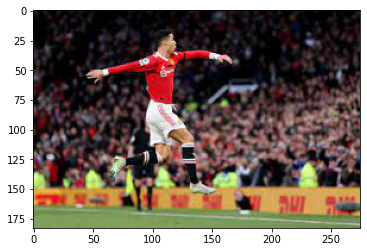

In [5]:
plt.imshow(content_img)
print(type(content_img))

Convert PIL   to Numpy array


In [6]:
content_img = tf.keras.preprocessing.image.img_to_array(content_img)
content_img = content_img / 255
content_img_batch = np.expand_dims(content_img, axis=0)
type(content_img_batch), content_img_batch.shape

(numpy.ndarray, (1, 183, 275, 3))

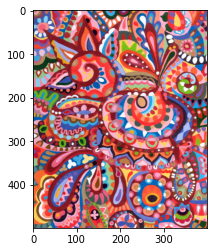

In [62]:
style_img = tf.keras.preprocessing.image.load_img('style1.jpg')
plt.imshow(style_img)

In [72]:
style_img = tf.keras.preprocessing.image.img_to_array(style_img)
style_img_batch = style_img[tf.newaxis, :] / 255
type(style_img_batch), style_img_batch.shape

(numpy.ndarray, (1, 500, 400, 3))

#Model

In [9]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

In [10]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False,  weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  network = tf.keras.Model(inputs=[vgg.input], outputs = outputs)
  return network

In [11]:
style_extractor = vgg_layers(style_layers)
style_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Generate Loss between the content image and the style image

In [12]:
def gram_matrix(layer_activation):
    results = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    
    return results / num_locations 

In [13]:
style_outputs = style_extractor.outputs

In [14]:
gram_matrix(style_outputs[0])

<KerasTensor: shape=(None, 64, 64) dtype=float32 (created by layer 'tf.math.truediv')>

In [127]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg =  vgg_layers(style_layers+content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.vgg.trainable = False
  
  def call(self, inputs):
    style_count = len(self.style_layers)
    inputs = inputs * 255.0  # [0-1] ==> [0, 255]
    # [0, 255] ==> [-127.5, 127.5]
    preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_inputs)
    style_outputs = outputs[:style_count]
    content_outputs = outputs[style_count:]
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [128]:
extractor = StyleContentModel(style_layers, content_layers)

In [129]:
style_layers, content_layers

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 ['block4_conv2'])

In [130]:
results = extractor(content_img_batch)
results.keys()

dict_keys(['content', 'style'])

#train

In [136]:
style_targets = extractor(style_img_batch)['style']
content_targets = extractor(content_img_batch)['content']

In [137]:
new_image = tf.Variable(content_img_batch)

In [138]:
content_weight = 1
style_weight = 1000

In [139]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

epoch 0 --- style loss 227080536064.0 --- content loss 726083.25 --- total loss 45416108261376.0


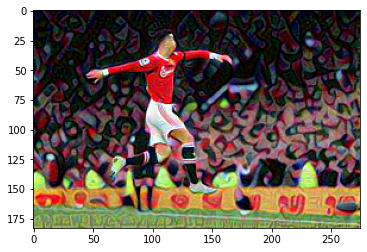

epoch 500 --- style loss 1708201472.0 --- content loss 1211155.125 --- total loss 341641494528.0


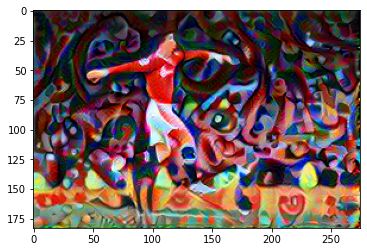

In [ ]:
epochs = 5000

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    outputs = extractor(new_image)

    content_outputs = outputs['content']
    style_outputs = outputs['style']

    #MSE
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])

    #weighted loss
    total_loss = content_loss * content_weight / len(content_layers) +  style_loss * style_weight / len(style_layers)

  #tells the direction to update the image
  gradient = tape.gradient(total_loss, new_image)
  optimizer.apply_gradients([(gradient, new_image)])

  #make sure pixels are at range [0, 1]
  new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))
  if epoch % 500 == 0:
    print(f'epoch {epoch} --- style loss {style_loss} --- content loss {content_loss} --- total loss {total_loss}')
    plt.imshow(tf.squeeze(new_image,  axis=0))
    plt.show()